In [1]:
import os, sys
sys.path.append("../../")
import json
import glob
import re
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.cm import ScalarMappable
from collections import Counter
from plotnine import *
from pathlib import Path
from utils import *
from matplotlib.cm import viridis
import argparse
import pickle
import pandas as pd
import itertools
from scipy.stats import bootstrap, ttest_rel
from collections import defaultdict, Counter
from evaluate import data_generator
from axbench import LatentStatsEvaluator
from tqdm import tqdm
import einops

from pyvene import (
    IntervenableConfig,
    IntervenableModel,
    SourcelessIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention,
    CollectIntervention
)

def apply_chat_template_to_input(row):
    messages = [{"role": "user", "content": row["input"]}]
    nobos = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)[1:]
    return tokenizer.decode(nobos)

def apply_chat_template_to_steered_input(row):
    messages = [{"role": "user", "content": row["steered_input"]}]
    nobos = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)[1:]
    return tokenizer.decode(nobos)
    
# set the theme
rcParams['font.family'] = "P052"
theme_set(theme_gray(base_family="P052") + theme(axis_text_x=element_text(angle=45, hjust=0.5)))

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.


In [2]:
def parse_string(s):
    pattern = r".*_bs(?P<bs>\d+)_epochs(?P<epochs>\d+)_lr(?P<lr>[0-9.]+)_layer(?P<layer>\d+)_scaler(?P<scaler>[0-9.]+)_do(?P<do>[0-9.]+)_ipdo(?P<ipdo>[0-9.]+)_(?P<prompt>blend|prepe)_(?P<negate>null|norm)_ol(?P<ol>\d+)(?:_.*)?"
    m = re.search(pattern, s)
    if m:
        d = m.groupdict()
        d['bs'] = int(d['bs'])
        d['epochs'] = int(d['epochs'])
        d['lr'] = float(d['lr'])
        d['layer'] = int(d['layer'])
        d['scaler'] = float(d['scaler'])
        d['do'] = float(d['do'])
        d['ipdo'] = float(d['ipdo'])
        d['ol'] = int(d['ol'])
        prompt_map = {"blend": "blend_in", "prepe": "prepend"}
        negate_map = {"null": "null_it_out", "norm": "subtraction"}
        d["prompt_type"] = prompt_map[d.pop("prompt")]
        d["negate_type"] = negate_map[d.pop("negate")]
        return d
    return {}

def get_steering_score(steering_jsonl_path):
    all_ratings = []
    with open(steering_jsonl_path, "r") as f:
        for line in f:
            data = json.loads(line)
            try:
                lm_judge_dict = data["results"]["LMJudgeEvaluator"]
                first_key = list(lm_judge_dict.keys())[0]
                rating_array = lm_judge_dict[first_key]["lm_judge_rating"]
            except (KeyError, IndexError):
                continue
            
            all_ratings.append(rating_array)
    return np.array(all_ratings).mean(axis=0).max()


def compute_run_score(jsonl_path):
    """
    Simplified function to compute the best score from steering.jsonl
    
    Args:
        jsonl_path: Path to the jsonl file
        
    Returns:
        tuple: (best_score, best_correlated_concept_id)
    """
    import json
    import numpy as np
    
    all_ratings = []
    concept_ids = []
    
    # Read and parse the jsonl file
    with open(jsonl_path, "r") as f:
        for line in f:
            data = json.loads(line)
            try:
                lm_judge_dict = data["results"]["LMJudgeEvaluator"]
                first_key = list(lm_judge_dict.keys())[0]
                rating_array = lm_judge_dict[first_key]["lm_judge_rating"]
                concept_id = data.get("concept_id")
                
                all_ratings.append(rating_array)
                concept_ids.append(concept_id)
            except (KeyError, IndexError):
                continue
    
    if not all_ratings:
        return None, None
    
    # Convert to numpy array
    ratings_arr = np.array(all_ratings)  # shape: (num_concepts, num_factors)
    
    # Calculate average ratings across concepts for each factor
    avg_ratings = ratings_arr.mean(axis=0)
    best_score = avg_ratings.max()
    
    # Find the concept that correlates most with the average trend
    best_correlation = -1
    best_correlated_concept_id = None
    
    for i, concept_id in enumerate(concept_ids):
        concept_ratings = all_ratings[i]
        corr_matrix = np.corrcoef(concept_ratings, avg_ratings)
        correlation = corr_matrix[0, 1]
        
        if correlation > best_correlation:
            best_correlation = correlation
            best_correlated_concept_id = concept_id
    
    return best_score, best_correlated_concept_id

def parse_model_and_length(folder_name):
    # Extract model name and length using regex
    match = re.match(r'(.+?)_(\d+)$', folder_name)
    if match:
        model_name = match.group(1)
        length = int(match.group(2))
        return model_name, length
    return None, None

def collect_results(results_dir):
    data = []
    
    # Walk through results directory
    for folder in os.listdir(results_dir):
        model_name, length = parse_model_and_length(folder)
        if model_name is None:
            continue
            
        # Look for steering.jsonl in evaluate folder
        jsonl_path = os.path.join(results_dir, folder, 'evaluate', 'steering.jsonl')
        if os.path.exists(jsonl_path):
            best_score, _ = compute_run_score(jsonl_path)  # Using your existing function
            data.append({
                'model': model_name,
                'length': length,
                'score': best_score
            })
    
    return pd.DataFrame(data)

def shorten_model_name(model_name):
    """
    Given a string like 'gemma-2-27b-it_prompt_steering',
    return a shortened version like 'Gemma-2 27B'.
    """
    pattern = r'^gemma-(\d+)-(\d+)b.*'
    match = re.match(pattern, model_name)
    if match:
        major_version = match.group(1)  # e.g. "2"
        model_size = match.group(2)    # e.g. "27"
        return f"Gemma-{major_version} {model_size}B"
    else:
        # Fallback if pattern doesn't match
        return model_name

def extract_major_version(model_name):
    """
    Return 'Gemma-2' if 'gemma-2' in the name,
    'Gemma-3' if 'gemma-3' in the name.
    """
    if 'gemma-2' in model_name:
        return 'Gemma-2'
    elif 'gemma-3' in model_name:
        return 'Gemma-3'
    else:
        return 'Other'

def extract_scores_and_factors(jsonl_path):
    """
    Extract factor values and average ratings across all entries in a steering.jsonl.
    
    Returns:
        tuple: (factors, avg_ratings), where factors is a list and avg_ratings is a numpy array.
    """
    all_ratings = []
    factor_values = None
    with open(jsonl_path, "r") as f:
        for line in f:
            data = json.loads(line)
            try:
                lm_judge_dict = data["results"]["LMJudgeEvaluator"]
                first_key = list(lm_judge_dict.keys())[0]
                rating_array = lm_judge_dict[first_key]["lm_judge_rating"]
                if factor_values is None:
                    factor_values = lm_judge_dict[first_key]["factor"]
                all_ratings.append(rating_array)
            except (KeyError, IndexError):
                continue
    if not all_ratings:
        return None, None
    ratings_arr = np.array(all_ratings)
    avg_ratings = ratings_arr.mean(axis=0)
    return factor_values, avg_ratings

def parse_run_and_setting_from_path(steering_file):
    """
    Parse metadata (run, setting, layer) from the file path.
    
    Returns a dictionary with keys 'run', 'setting', and 'layer'.
    """
    path_str = str(steering_file)
    info = {"run": None, "setting": None, "layer": None}
    match_run = re.search(r"stability_run_(\d+)", path_str)
    if match_run:
        info["run"] = f"Run {match_run.group(1)}"
    if "2_way_xros" in path_str:
        info["setting"] = "2_way_xros"
    elif "4_way" in path_str:
        info["setting"] = "4_way"
    match_layer = re.search(r"(layer\d+)_", path_str)
    if match_layer:
        info["layer"] = match_layer.group(1)
    return info

def collect_stability_results_recursive(base_dir):
    """
    Recursively collect data from all steering.jsonl files under base_dir.
    
    Returns:
        pd.DataFrame with columns: run, setting, layer, factor, score.
    """
    data = []
    for steering_file in Path(base_dir).rglob('steering.jsonl'):
        info = parse_run_and_setting_from_path(steering_file)
        factors, scores = extract_scores_and_factors(str(steering_file))
        if factors is not None:
            for factor, score in zip(factors, scores):
                data.append({
                    'run': info["run"],
                    'setting': info["setting"],
                    'layer': info["layer"],
                    'factor': factor,
                    'score': score
                })
    return pd.DataFrame(data)

def create_stability_plots(df):
    """
    Build stability analysis plots (one per setting) with:
      - Individual run lines,
      - A bold black mean line,
      - A ribbon for mean ± std.
    
    Returns:
        dict mapping each setting to its ggplot object.
    """
    summary_df = (
        df.groupby(['setting', 'factor'], dropna=False)['score']
          .agg(['mean', 'std'])
          .reset_index()
          .rename(columns={'mean': 'mean_score', 'std': 'std_score'})
    )
    
    plots = {}
    for setting in df['setting'].dropna().unique():
        sub_df = df[df['setting'] == setting]
        sub_summary = summary_df[summary_df['setting'] == setting]
        p = (ggplot() +
             geom_line(
                 data=sub_df,
                 mapping=aes(x='factor', y='score', group='run', color='run'),
                 alpha=0.5
             ) +
             geom_line(
                 data=sub_summary,
                 mapping=aes(x='factor', y='mean_score'),
                 color='black', size=1.2
             ) +
             geom_ribbon(
                 data=sub_summary,
                 mapping=aes(x='factor', ymin='mean_score - std_score', ymax='mean_score + std_score'),
                 alpha=0.2
             ) +
             labs(
                 title=f"Stability Analysis - {setting}",
                 x="Steering Factor",
                 y="Average Score"
             ) +
             theme_minimal() +
             theme(
                 figure_size=(8, 8),
                 panel_grid_major=element_line(color="gray", size=0.5),
                 panel_grid_minor=element_line(color="lightgray", size=0.25)
             )
        )
        plots[setting] = p
    return plots

In [3]:
PLOT_FOLDER = "paper/"

### Model generation length analyses

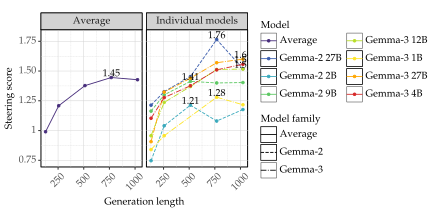

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//model_generation_length.pdf


In [4]:
%config InlineBackend.figure_format = 'svg'

results_dir = '/nlp/scr/wuzhengx/preference-vectors/axbench/prompt_results/'
df = collect_results(results_dir)

df = df.sort_values(['model', 'length'])

df['Model'] = df['model'].apply(shorten_model_name)
df['Model family'] = df['model'].apply(extract_major_version)

avg_df = df.groupby('length')['score'].mean().reset_index()
avg_df['Model'] = 'Average'
avg_df['Model family'] = 'Average'

df['panel'] = 'Individual models'
avg_df['panel'] = 'Average'

combined_df = pd.concat([df, avg_df], ignore_index=True)

# Find maximum scores for annotation
max_df = combined_df.loc[combined_df.groupby(['panel', 'Model'])['score'].idxmax()].reset_index(drop=True)
max_df['label'] = max_df['score'].apply(lambda s: f"{s:.2f}")

# Example custom color palette - adjust colors as needed
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Build the plot with enhanced styling
plot = (
    ggplot(combined_df, aes(
        x='length',
        y='score',
        color='Model',
        group='Model',
        linetype='Model family'
    ))
    + geom_line(size=0.5)
    + geom_point(size=1)
    + facet_wrap('~ panel', nrow=1, scales='free_x')
    + scale_color_manual(values=model_colors)
    + labs(
        x='Generation length', 
        y='Steering score'
    )
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position='right',
        legend_box='vertical',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(6, 3),
    )
    # Annotate maximum points
    + geom_text(
        data=max_df,
        mapping=aes(x='length', y='score', label='label'),
        nudge_x=0.8,
        nudge_y=0.03,
        va='center',
        ha='center',
        color='black',
        size=10
    )
    # Add guides to control legend layout
    + guides(color=guide_legend(ncol=2))
)

print(plot)
# Display the plot
plot.save(f"{PLOT_FOLDER}/model_generation_length.pdf", width=6, height=3)

### Stability check across runs

Collected 84 data points.


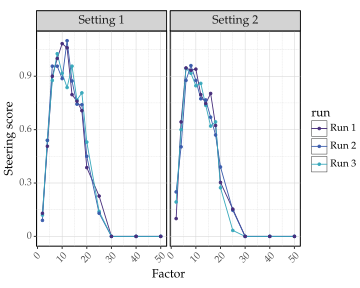

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//stability.pdf


In [42]:
base_dir = '../ht_results/stability_analyses/'  # Change as needed

# Collect data
df = collect_stability_results_recursive(base_dir)
print(f"Collected {len(df)} data points.")

# Use the extended color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Create a mapping dictionary
setting_labels = {
    '2_way_xros': 'Setting 1',
    '4_way': 'Setting 2',
}
df['setting'] = df['setting'].map(setting_labels)

# Compute a DataFrame that holds the maximum score for each (setting, run)
max_df = df.loc[df.groupby(['setting', 'run'])['score'].idxmax()].reset_index(drop=True)

# Create a new column with the score formatted to 2 decimal places
max_df['label'] = max_df['score'].apply(lambda s: f"{s:.2f}")

plot = (
    ggplot(df, aes(x='factor', y='score', color='run', group='run'))
    + geom_line(size=0.5)
    + geom_point(size=1)
    # Create side-by-side panels based on the 'setting' column
    + facet_wrap('~setting', nrow=1, scales='free_x')
    # Axis labels (no overall title)
    + labs(
        x='Factor', 
        y='Steering score'
    )
    # Use the extended color palette
    + scale_color_manual(values=model_colors)
    # Apply a minimal theme with additional style adjustments
    + theme(
        # Style for facet labels with black border
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=12),
        # Suppress any main title (and associated space)
        plot_title=element_text(size=0),
        # Axis text and title sizes
        axis_text=element_text(size=10),
        axis_title=element_text(size=12),
        # Legend is placed on the right; each key is given a black border
        legend_position='right',
        legend_box='vertical',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        # Light gridlines for reference
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        # White background with a border around each panel
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Overall figure size
        figure_size=(5, 4),
    )
    # # Annotate the maximal points
    # + geom_text(
    #     data=max_df,
    #     mapping=aes(x='factor', y='score', label='label'),
    #     nudge_x=0.8,
    #     nudge_y=0.03,
    #     va='center',
    #     ha='center',
    #     color='black',
    #     size=12
    # )
)
print(plot)
# Display the plot
plot.save(f"{PLOT_FOLDER}/stability.pdf", width=5, height=2.5)

### Layernorm

In [3]:
model_name = "2b"
model = AutoModelForCausalLM.from_pretrained(
    f"google/gemma-2-{model_name}-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    f"google/gemma-2-{model_name}-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# read in a training dataset
dpo_train_data = pd.read_parquet("../concept1/generate/dpo_train_data.parquet")
dpo_train_data['input'] = dpo_train_data.apply(apply_chat_template_to_input, axis=1)
batch_size = 8
prefix_length = 1
tokenizer.padding_side = "right"

In [6]:
layer_norms_2b = collect_all_layer_activations(
    model,
    dpo_train_data,
    tokenizer,
    layer_range=range(0, model.config.num_hidden_layers, 2),  # Example: every other layer from 0 to 11
    batch_size=batch_size,
    max_examples=100  # Limit for testing
)

Layer 0: Collected 72 norm values
Layer 2: Collected 72 norm values
Layer 4: Collected 72 norm values
Layer 6: Collected 72 norm values
Layer 8: Collected 72 norm values
Layer 10: Collected 72 norm values
Layer 12: Collected 72 norm values
Layer 14: Collected 72 norm values
Layer 16: Collected 72 norm values
Layer 18: Collected 72 norm values
Layer 20: Collected 72 norm values
Layer 22: Collected 72 norm values
Layer 24: Collected 72 norm values


In [9]:
model_name = "9b"
model = AutoModelForCausalLM.from_pretrained(
    f"google/gemma-2-{model_name}-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    f"google/gemma-2-{model_name}-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
layer_norms_9b = collect_all_layer_activations(
    model,
    dpo_train_data,
    tokenizer,
    layer_range=range(0, model.config.num_hidden_layers, 2),  # Example: every other layer from 0 to 11
    batch_size=batch_size,
    max_examples=100  # Limit for testing
)

Layer 0: Collected 72 norm values
Layer 2: Collected 72 norm values
Layer 4: Collected 72 norm values
Layer 6: Collected 72 norm values
Layer 8: Collected 72 norm values
Layer 10: Collected 72 norm values
Layer 12: Collected 72 norm values
Layer 14: Collected 72 norm values
Layer 16: Collected 72 norm values
Layer 18: Collected 72 norm values
Layer 20: Collected 72 norm values
Layer 22: Collected 72 norm values
Layer 24: Collected 72 norm values
Layer 26: Collected 72 norm values
Layer 28: Collected 72 norm values
Layer 30: Collected 72 norm values
Layer 32: Collected 72 norm values
Layer 34: Collected 72 norm values
Layer 36: Collected 72 norm values
Layer 38: Collected 72 norm values
Layer 40: Collected 72 norm values


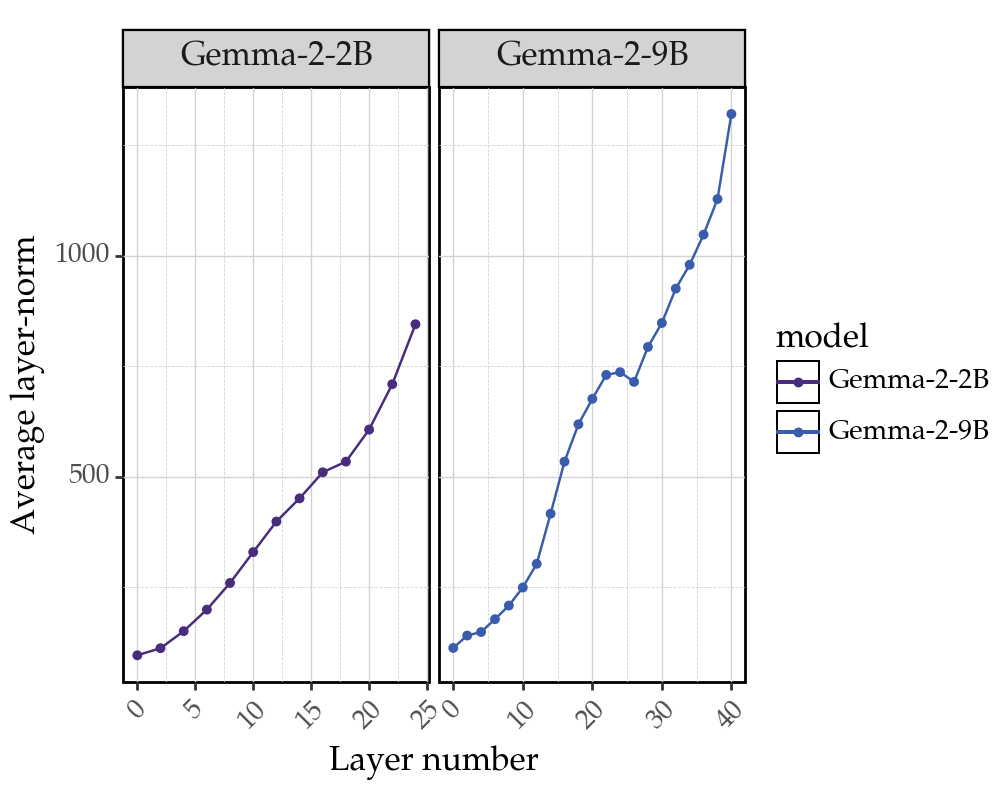

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//gemma-2-layernorm.pdf


In [17]:
# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Assuming the tensors are stored in dictionaries as shown
layer_data = {
    'Gemma-2-2B': layer_norms_2b,
    'Gemma-2-9B': layer_norms_9b
}

# Process the data into a pandas DataFrame
data_list = []
for model_name, model_data in layer_data.items():
    for layer_num, tensor_data in model_data.items():
        # Convert tensor to numpy and calculate mean
        mean_value = tensor_data.float().numpy().mean()
        data_list.append({
            'model': model_name,
            'layer': layer_num,
            'mean_norm': mean_value
        })

# Create DataFrame
df = pd.DataFrame(data_list)

# Calculate max values for annotation
max_df = df.loc[df.groupby(['model'])['mean_norm'].idxmax()].reset_index(drop=True)
max_df['label'] = max_df['mean_norm'].apply(lambda s: f"{s:.2f}")

# Define custom model names if needed
model_labels = {
    'Gemma-2-2B': 'Gemma-2-2B',
    'Gemma-2-9B': 'Gemma-2-9B'
}

# Apply the mapping
df['model_type'] = df['model'].map(model_labels)

# Create the plot
plot = (
    ggplot(df, aes(x='layer', y='mean_norm', color='model', group='model'))
    + geom_line(size=0.5)
    + geom_point(size=1)
    # Create side-by-side panels based on the 'model_type' column
    + facet_wrap('~model_type', nrow=1, scales='free_x')
    # Axis labels
    + labs(
        x='Layer number', 
        y='Average layer-norm'
    )
    # Use the first two colors from our palette
    + scale_color_manual(values=model_colors[:2])
    + theme(
        # Style for facet labels with black border
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=12),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=12),
        # Legend styling
        legend_position='right',
        legend_box='vertical',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(5, 4),
    )
)
print(plot)
# Display the plot
plot.save(f"{PLOT_FOLDER}/gemma-2-layernorm.pdf", width=5, height=2.5)

### Sampling factor on performance variance

In [34]:
ht_results_dir = "../ht_results_remove/gemma-2-9b-it_hparam_tuning/"
model = "gemma-2-9b-it"
method = "scaled_simpo"

layers = [16, 20, 24]
preference_pairs = ["2_way"]
runs_df = []
for l in layers:
    for pp in preference_pairs:
        folder_path = os.path.join(ht_results_dir, f"layer{l}_p_vector_{pp}")
        for run_folder in os.scandir(folder_path):
            if run_folder.is_dir():
                if "scaled_simpo" in run_folder.path and "null" in run_folder.path: # we use null it out to control
                    run_config = parse_string(run_folder.path)
                    run_config["preference_pair"] = pp # pp is not parsed from the folder name
                    steering_s = get_steering_score(os.path.join(run_folder.path, "evaluate_ol768/steering.jsonl"))
                    run_config["steering_score"] = steering_s
                    runs_df += [run_config]
runs_df_with_factor = pd.DataFrame(runs_df)

layers = [16, 20, 24]
preference_pairs = ["2_way"]
runs_df = []
for l in layers:
    for pp in preference_pairs:
        folder_path = os.path.join(ht_results_dir, f"layer{l}_p_vector_{pp}_no_factor")
        for run_folder in os.scandir(folder_path):
            if run_folder.is_dir():
                if "scaled_simpo" in run_folder.path and "null" in run_folder.path: # ablate from null it out condition
                    run_config = parse_string(run_folder.path)
                    run_config["preference_pair"] = pp # pp is not parsed from the folder name
                    jsonl_file_path = os.path.join(run_folder.path, "evaluate_ol768/steering.jsonl")
                    if not os.path.isfile(jsonl_file_path):
                        print(f"Missing file: {jsonl_file_path}")
                        continue
                    steering_s = get_steering_score(jsonl_file_path)
                    run_config["steering_score"] = steering_s
                    runs_df += [run_config]
runs_df_without_factor = pd.DataFrame(runs_df)

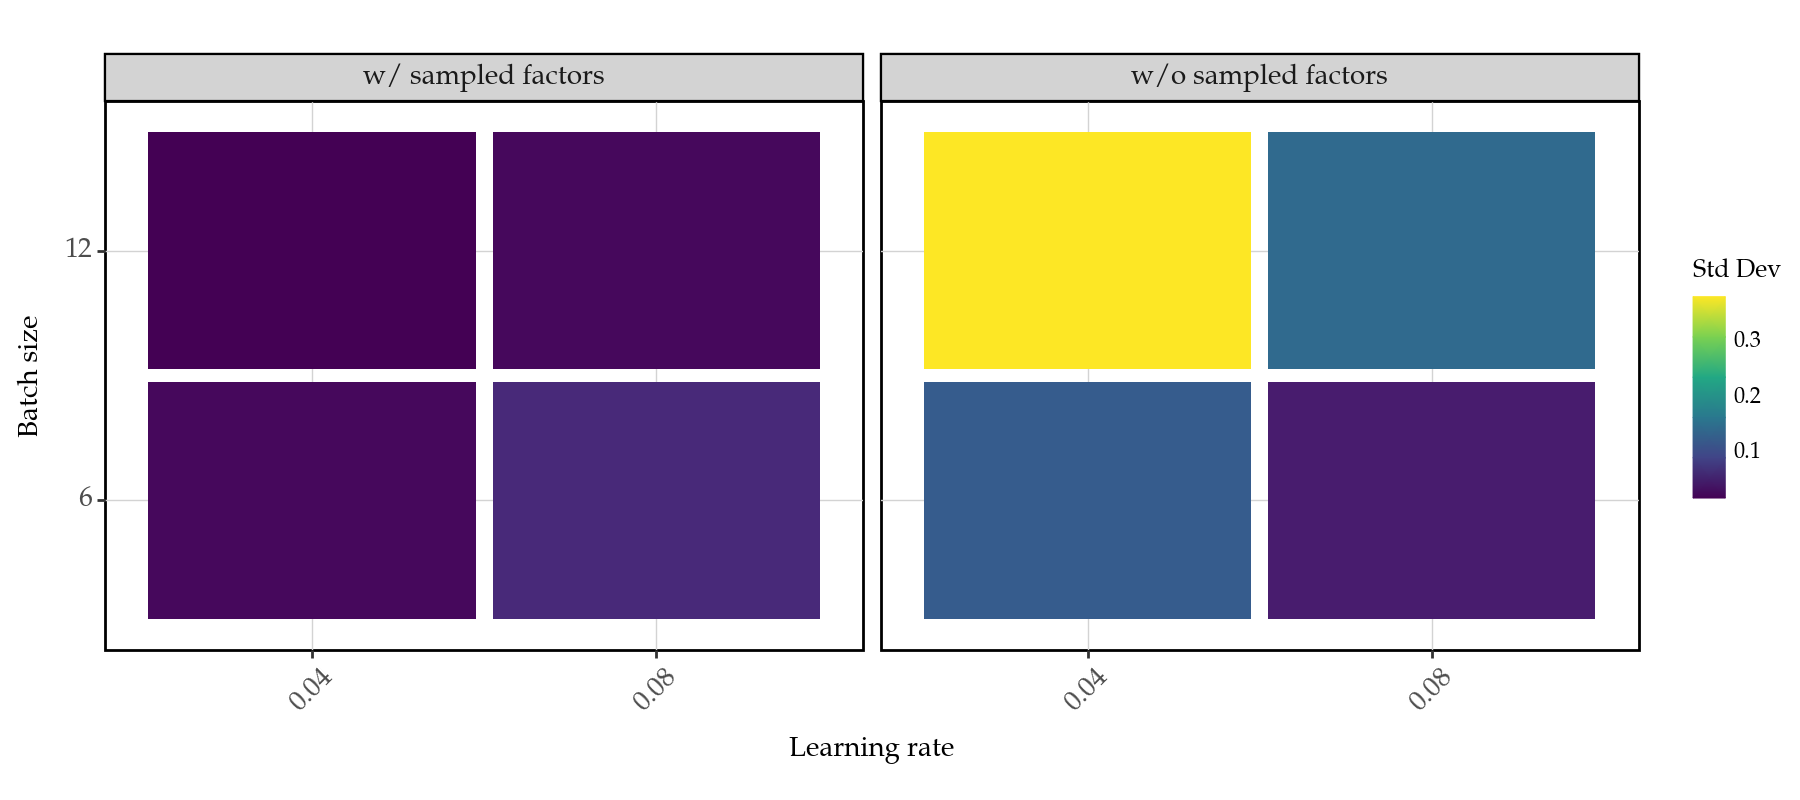

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//factor-run-variance.pdf


In [56]:
# Assuming the two dataframes are loaded as df1 and df2
# First, add a 'Run' column to identify each dataframe
runs_df_with_factor['Run'] = 'w/ sampled factors'
runs_df_without_factor['Run'] = 'w/o sampled factors'

# Combine the dataframes
combined_df = pd.concat([runs_df_with_factor, runs_df_without_factor])

# Group by the key hyperparameters and calculate mean and std of steering_score
agg_df = combined_df.groupby(['Run', 'bs', 'lr']).agg(
    mean_score=('steering_score', 'mean'),
    std_score=('steering_score', 'std')
).reset_index()

viridis_colors = [viridis(i/255) for i in range(256)]

# Create the variance plot with Viridis color palette
plot = (
    ggplot(agg_df, aes(
        x='factor(lr)',
        y='factor(bs)',
        fill='std_score'
    ))
    + geom_tile(aes(width=0.95, height=0.95))
    + facet_wrap('~ Run', nrow=1)
    + scale_fill_gradientn(colors=viridis_colors)  # Using Viridis color palette
    + labs(
        x='Learning rate', 
        y='Batch size',
        fill='Std Dev'
    )
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position='right',
        legend_box='vertical',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_key_height=10,  # Make legend keys smaller
        legend_key_width=10,  # Make legend keys smaller
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_blank(),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size - increase width to accommodate legend
        figure_size=(9, 4),
    )
    # Make the colorbar shorter with fewer breaks
    + guides(fill=guide_colorbar(
        barwidth=8,  # narrower bar
        barheight=10,  # shorter bar
        nbin=6,  # fewer color segments
        raster=True,  # rasterize for better rendering
        ticks=False,  # remove ticks
    ))
)
print(plot)
# Display the plot
plot.save(f"{PLOT_FOLDER}/factor-run-variance.pdf", width=5, height=3)

### Generation analyses

In [63]:
lm_vectors_dir = "../results_concept500_v1/prod_9b_l20_concept500_c_vector/evaluate/steering_data.parquet"
preference_vectors_dir = "../results_concept500_v1/prod_9b_l20_concept500_dps/evaluate/steering_data.parquet"
lm_df = pd.read_parquet(lm_vectors_dir)
preference_df = pd.read_parquet(preference_vectors_dir)
demo_concept_id = 499
lm_concept_df = lm_df[lm_df["concept_id"] == demo_concept_id]
preference_concept_df = preference_df[preference_df["concept_id"] == demo_concept_id]

In [78]:
lm_concept_df[(lm_concept_df["input_id"]==4)&(lm_concept_df["factor"]==40.0)].input.tolist()

['<start_of_turn>user\nWhat are some herbs I can dry out?<end_of_turn>\n<start_of_turn>model\n']

In [82]:
lm_concept_df[(lm_concept_df["input_id"]==4)&(lm_concept_df["factor"]==40.0)].input_concept.tolist()

['positive sentiments and descriptions of enjoyable experiences']

In [75]:
lm_concept_df[(lm_concept_df["input_id"]==4)&(lm_concept_df["factor"]==40.0)].ConceptVector_steered_generation.tolist()

[' listeners, that to comes lets about, on we of that and, is – in, on, stands,, is, pure,, is, that on, stands: is,, about to, bright is, that in, like, joyful, delightful, while, is, delightful, delightful is,, joyous joyful,, that is is, atvening, of, may, with, at, is,, captures, is,, delightful once, once,, in our memorable days, that from [that resonates, many of, that we, at once,, in one, is, is, that listeners, again']

In [76]:
preference_concept_df[(preference_concept_df["input_id"]==4)&(preference_concept_df["factor"]==40.0)].PreferenceVector_steered_generation.tolist()

['The vibrant and warm moments of pure joy invites, like when you savates, where the delight dance unfolds, like the sweet delight that, the song resonates around, as you, to create a joyful setting, where such moments to savor,that,the joyous gathering,such,at the sun-shining moment shines,a joyous gathering that brings delight,for music,when it brightens our hearts around fills at the delight,we comes,oh,how bright invites,the delight that flows,captures,like the moments we savates,how the joyful moments around,those radiant moments when full,Oh,when you dances that warms']

### Factor v.s. steering score plot

In [5]:
RESULTS_FOLDERS = [
    "/nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1/",
]
SUBFOLDERS = [
    "prod_2b_l20_concept500",
    "prod_2b_l10_concept500",
    "prod_9b_l20_concept500",
    "prod_9b_l31_concept500",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
    # "prod_27b_l28_concept100"
    # "prod_12b_l22_concept100"
    # "prod_12b_l18_concept100"
]
METHODS = [
    # RePS v.s. Lang. in SV
    "dps",
    "c_vector",
    # RePS v.s. Lang. in LoRA
    "p_lora_dps",
    "c_lora",
    # RePS v.s. Lang. in ReFT
    "p_loreft_dps",
    "c_loreft",
]
METHOD_MAP = {
    "PreferenceVector": "SV w/ RePS",
    "ConceptVector": "SV w/ Lang.",
    "PreferenceLoRA": "LoRA w/ RePS",
    "ConceptLoRA": "LoRA w/ Lang.",
    "PreferenceLoReFT": "LoReFT w/ RePS",
    "ConceptLoReFT": "LoReFT w/ Lang.",
    # "PromptSteering": "Prompt",
    # "GemmaScopeSAE": "SAE",
    # "c_vector_nfs": "LM w/o factor",
    # "p_lora_dps": "p_lora_dps",
    # "p_vector_bipo_lf": "p_vector_bipo_lf",
    # "p_loreft_dps": "p_loreft_dps",
    # "p_loreft_bipo": "p_loreft_bipo",
    # "c_loreft": "c_loreft",
    # "p_lora_bipo": "p_lora_bipo",
    # "c_lora": "c_lora",
    # "p_vector_dps": "p_vector_dps", 
    # "prompt_steering": "Prompt",
    # "prompt": "Prompt"
}
MODEL_MAP = {
    "2b": "Gemma-2-2B",
    "9b": "Gemma-2-9B",
    "12b": "Gemma-3-12B",
    "27b": "Gemma-3-27B",
}
LAYER_MAP = {
    "l10": "L10",
    "l20": "L20",
    "l31": "L31",
    "l22": "L22",
    "l28": "L28",
    "l18": "L18",
}
METRIC_MAP = {
    "macro_avg_accuracy": "Acc. (macro-avg)",
    "max_act": "Max Act.",
    "optimal_threshold": "Optimal Thresh.",
    "roc_auc": "AUROC",
    "max_lm_judge_rating": "Overall Score",
    "max_fluency_rating": "Fluency Score",
    "max_relevance_concept_rating": "Concept Score",
    "max_relevance_instruction_rating": "Instruct Score",
    "max_factor": "Steering Factor",
    "overall_accuracy": "Overall Accuracy",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
}
FLOAT_METRICS = ['macro_avg_accuracy', 'max_act', 'optimal_threshold', 'roc_auc',
                 'max_lm_judge_rating', 'max_fluency_rating', 'max_relevance_concept_rating',
                 'max_relevance_instruction_rating', 'max_factor', 'overall_accuracy',
                 'f1', 'precision', 'recall', 'max_act_val', 'min_act_val']
INT_METRICS = ['concept_id']

def prettify_df(df):
    # rename columns
    for metric in FLOAT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(float)
    for metric in INT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(int)
    if "method" in df.columns:
        df["method"] = df["method"].apply(lambda x: METHOD_MAP.get(x, x))
        df = df.rename(columns={"method": "Method"})
    if "model" in df.columns:
        df["model"] = df["model"].apply(lambda x: MODEL_MAP.get(x, x))
    if "layer" in df.columns:
        df["layer"] = df["layer"].apply(lambda x: LAYER_MAP.get(x, x))
    df.columns = [METRIC_MAP[col] if col in METRIC_MAP else col for col in df.columns]
    return df


def mean_and_ci(group, n_bootstraps=1000, ci=0.95):
    values = group["values"].values
    # Compute mean
    mean_value = np.mean(values)
    if np.isnan(mean_value):
        print(values)
        print("bruh its nan")
    # Compute bootstrap CI
    result = bootstrap(
        data=(values,),
        statistic=np.mean,
        n_resamples=n_bootstraps,
        confidence_level=ci,
        method="percentile"
    )
    lower_ci, upper_ci = result.confidence_interval
    return pd.Series({"mean": mean_value, "lower_ci": lower_ci, "upper_ci": upper_ci})


def format_ci(mean, lower_ci, upper_ci, only_mean=False, percent=False):
    result = ""
    if only_mean:
        if percent:
            result = f"{mean:.1%}"
        else:
            result = f"{mean:.3f}"
    else:
        if percent:
            result = f"{mean:.1%}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
        else:
            result = f"{mean:.3f}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
    result = result.replace("%", "\\%")
    return result


def split_metric(metric):
    splitted = metric.split(".")
    if len(splitted) > 4:
        splitted[3] = '.'.join(splitted[3:])
    return tuple(splitted[:4])

In [6]:
no_factor = ["Prompt", "LoReFT", "LoRA", "SFT"]
id_vars = ['concept_id', 'model', 'layer', 'split', 'identifier']

def agg_first_non_nan(vals):
    for val in vals:
        if isinstance(val, list) or np.all(val):
            return val
    return vals.iloc[0]

def format_df(df: pd.DataFrame):
    # rename steering_test columns
    steering_test_exists = False
    for col in df.columns:
        if "steering_test" in col:
            df = df.rename(columns={col: col.replace("steering_test", "steering") + "_test"})
            steering_test_exists = True

    # make each method a row
    value_vars = [col for col in df.columns if col not in id_vars]
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='value')
    melted_df["method"] = melted_df["metric"].apply(lambda x: METHOD_MAP.get(x.split(".")[2], x.split(".")[2]))
    melted_df["metric"] = melted_df["metric"].apply(lambda x: ".".join(x.split(".")[3:]))
    pivot_df = melted_df.pivot_table(index=id_vars + ['method'], columns='metric', values='value', aggfunc=agg_first_non_nan).reset_index()
    
    # steering metrics
    steering_metrics = ["lm_judge_rating", "fluency_ratings", "relevance_concept_ratings", "relevance_instruction_ratings"]
    for metric in steering_metrics: # for non-factor methods, pick a random subset
        pivot_df[metric] = pivot_df.apply(lambda row: random.choice(row[metric]) if isinstance(row[metric], list) and row["method"] in no_factor else row[metric], axis=1)
    pivot_df["max_lm_judge_rating_idx"] = pivot_df["lm_judge_rating"].apply(lambda x: np.argmax(x) if isinstance(x, list) else 0)
    if steering_test_exists:
        pivot_df["max_lm_judge_rating"] = pivot_df.apply(lambda row: row["lm_judge_rating_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["lm_judge_rating_test"], list) else row["lm_judge_rating_test"], axis=1)
        pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings_test"], list) else row["fluency_ratings_test"], axis=1)
        pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings_test"], list) else row["relevance_concept_ratings_test"], axis=1)
        pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings_test"], list) else row["relevance_instruction_ratings_test"], axis=1)
        pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor_test"], list) else row["factor_test"], axis=1)
    else:
        pivot_df["max_lm_judge_rating"] = pivot_df.apply(lambda row: row["lm_judge_rating"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["lm_judge_rating"], list) else row["lm_judge_rating"], axis=1)
        pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings"], list) else row["fluency_ratings"], axis=1)
        pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings"], list) else row["relevance_concept_ratings"], axis=1)
        pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings"], list) else row["relevance_instruction_ratings"], axis=1)
        pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor"], list) else row["factor"], axis=1)
    
    # fix types
    pivot_df = prettify_df(pivot_df)
    return pivot_df

def process_folder(results_folder: str, folder: str, method: str):
    method_folder = f"{results_folder}/{folder}_{method}/evaluate"
    inference_folder = f"{results_folder}/{folder}_{method}/inference"
    if not os.path.exists(method_folder):
        print(f"could not find {method_folder}")
        return None
    print(f"found {method_folder}")
        
    # load latent eval
    megadict = defaultdict(dict)
    latent_eval = f"{method_folder}/latent.jsonl"
    if os.path.exists(latent_eval):
        print(f"Processing latent for {method}...")
        with open(latent_eval, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['latent'] = json_line['results']
    else:
        print(f"Skipping {method} because no latent.jsonl found")

    # load latent parquet
    if not os.path.exists(f"{inference_folder}/latent_data.parquet"):
        print(f"Skipping {method} because no latent.parquet found")
    else:
        print(f"Processing latent (more) for {method}...")
        df_generator = data_generator(inference_folder, mode="latent")
        for concept_id, temp_df in df_generator:
            eval_results = {}
            for m in METHOD_MAP:
                if f"{m}_max_act" not in temp_df.columns:
                    continue
                evaluator = LatentStatsEvaluator(m)
                eval_result = evaluator.compute_metrics(temp_df)
                eval_results[m] = eval_result
            if 'latent' not in megadict[concept_id]:
                megadict[concept_id]['latent'] = {}
            megadict[concept_id]['latent']['LatentStatsEvaluator'] = eval_results
    
    # load steering eval
    steering_eval = f"{method_folder}/steering.jsonl"
    steering_test = f"{method_folder}/steering_test.jsonl"
    if os.path.exists(steering_eval):
        print(f"Processing steering for {method}...")
        with open(steering_eval, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['steering'] = json_line['results']
    else:
        print(f"Skipping {method} because no steering.jsonl found")
    if os.path.exists(steering_test):
        print(f"Processing steering test for {method}...")
        with open(steering_test, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['steering_test'] = json_line['results']
    else:
        print(f"Skipping {method} because no steering_test.jsonl found")

    megalist = [{'concept_id': concept_id, **data} for concept_id, data in megadict.items()]
    df = pd.json_normalize(megalist)
    return df

In [7]:
reload = True
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    all_dfs = []
    for results_folder in RESULTS_FOLDERS:
        for folder in SUBFOLDERS:
            parts = folder.split("_")
            assert len(parts) == 4
            _, model, layer, split = parts
            dfs = []
            for method in METHODS:
                df = process_folder(results_folder, folder, method)
                if df is not None:
                    dfs.append(df)
                    print(len(df))
                    # for column in df.columns:
                    #     print(column, df[column].iloc[0])
        
            # merge dfs based on concept_id column, pick the first one
            if len(dfs) == 0:
                continue
            df = pd.concat(dfs)
            # print(list(df.columns))
            # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
            df = df.groupby("concept_id").first().reset_index()
            df["model"] = MODEL_MAP[model]
            df["layer"] = LAYER_MAP[layer]
            df["split"] = split
            df["identifier"] = f"{model}, {layer}, {split}"
            all_dfs.append(format_df(df))

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_dps/evaluate
Processing latent for dps...
Processing latent (more) for dps...
Processing steering for dps...
Processing steering test for dps...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_c_vector/evaluate
Processing latent for c_vector...
Processing latent (more) for c_vector...
Processing steering for c_vector...
Processing steering test for c_vector...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_p_lora_dps/evaluate
Skipping p_lora_dps because no latent.jsonl found
Skipping p_lora_dps because no latent.parquet found
Processing steering for p_lora_dps...
Processing steering test for p_lora_dps...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_c_lora/evaluate
Skipping c_lora because no latent.jsonl found
Skipping c_lora beca

In [8]:
print(len(df))
df = df[df["split"] == "concept500"]
print(len(df))
ignore = []

12000
12000


In [9]:
# make latex table
detection_order = []
steering_order = []
for metric in ["Overall Score",]:
    with open(f"{PLOT_FOLDER}/{split}_{metric}.txt", "w") as f:
        for only_mean in [True, False]:
            df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
            df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
            # print count of nans
            f.write("NaN count:\n")
            for method in df_subset["Method"].unique():
                f.write(f"{method}: {sum(df_subset[df_subset['Method'] == method]['values'].apply(lambda x: np.isnan(x)))}\n")
            avg_df = df_subset.copy()
            avg_df["identifier"] = "Average"
            df_subset = pd.concat([df_subset, avg_df])
            df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
            
            # Append the averages to the original dataframe
            df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
            df_subset = df_subset.sort_values(by="Average", ascending=False)

            # df_subset_avg = df.copy()
            # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
            # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
            # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
            # df_subset = df_subset.sort_values(by="Average", ascending=False)
            if metric == "AUROC":
                detection_order = df_subset["Method"].tolist()
            elif metric == "Overall Score":
                steering_order = df_subset["Method"].tolist()
            elif metric in ["Winrate"]:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
            else:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
            flattened = df_subset.to_latex(index=False)
            f.write(flattened)
            f.write("\n\n")

        # do paired t test on Latent AUROC between each pair of methods
        df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
        df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
        for identifier in list(df_subset["identifier"].unique()) + [None]:
            for method1, method2 in itertools.combinations(df["Method"].unique(), 2):
                df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
                if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                    continue
                roc_auc_1 = list(df_subset_t[method1])
                roc_auc_2 = list(df_subset_t[method2])
                # print all nans
                method1_nan = sum(np.isnan(roc_auc_1))
                method2_nan = sum(np.isnan(roc_auc_2))
                if method1_nan > 0 or method2_nan > 0:
                    # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                    continue
                t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
                f.write(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}\n")

/tmp/wuzhengx/ipykernel_3346348/1724581732.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/wuzhengx/ipykernel_3346348/1724581732.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [10]:
df_all = df.copy()
df = df[~df["Method"].isin(ignore)]
df["Method"].unique()

array(['LoRA w/ Lang.', 'LoRA w/ RePS', 'LoReFT w/ Lang.',
       'LoReFT w/ RePS', 'SV w/ Lang.', 'SV w/ RePS'], dtype=object)

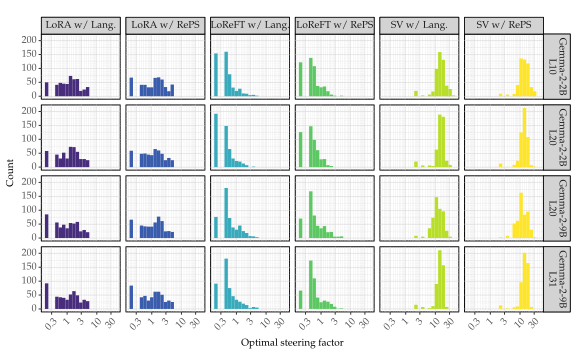

<Figure Size: (800 x 500)>

In [11]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]

model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
plot = (
    ggplot(df_subset, aes(x="Steering Factor", fill="Method"))
    + geom_histogram(bins=21)
    + facet_grid('model + layer ~ Method')
    + labs(x="Optimal steering factor", y="Count", fill="")
    + scale_x_log10()
    # Use one of these color scales depending on your preference:
    + scale_fill_manual(values=model_colors[:len(df_subset["Method"].unique())])  # Using your custom colors 
    # + scale_fill_gradientn(colors=viridis_colors)  # Or using Viridis
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position="none",  # Keeping your preference for no legend
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(8, 5),
    )
)

plot
# plot.save(f"{PLOT_FOLDER}/{split}_optimal_factor.pdf", width=9, height=5) 

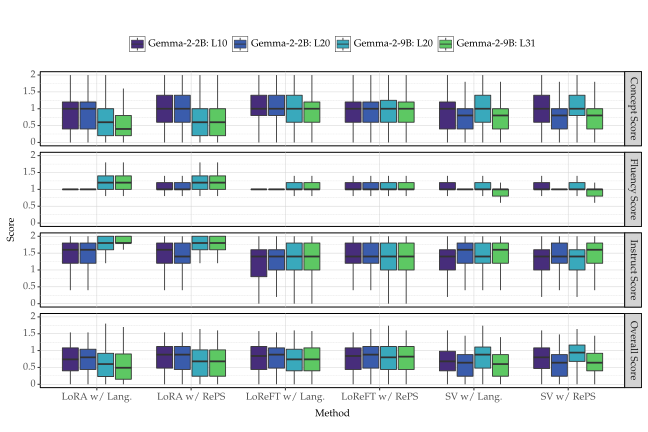

<Figure Size: (900 x 600)>

In [12]:
# plot each steering metric
df_subset = df.copy()[["Method", "model", "layer", "identifier", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
df_subset = df_subset.dropna(subset=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score", "model", "layer"])
df_subset = df_subset.melt(id_vars=["Method", "model", "layer", "identifier"], value_vars=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score"], var_name="metric", value_name="value")
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=[x for x in steering_order if x not in ignore])
# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
method_order = sorted(df_subset["Method"].unique())
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=method_order, ordered=True)
plot = (
    ggplot(df_subset, aes(x="Method", y="value", fill='model + ": " + layer'))
    + facet_grid("metric~")
    + geom_boxplot(outlier_shape="", position=position_dodge2(preserve="single"))
    + labs(fill="", y="Score")
    + scale_fill_manual(values=model_colors)
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        axis_text_x=element_text(angle=0, hjust=0.5),
        # Legend styling
        legend_position="top",
        legend_box="horizontal",
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(9, 6),
    )
    + guides(fill=guide_legend(ncol=4))
)
plot
# plot.save(f"{PLOT_FOLDER}/{split}_steering.pdf", width=9, height=6)

In [13]:
# plot factor vs score
factor_df = df_all.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if x not in no_factor])

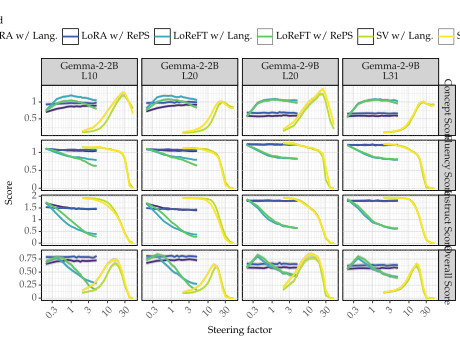

<Figure Size: (640 x 480)>

In [14]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if (x not in no_factor) and (x not in ignore)])
factor_df = factor_df_og.melt(id_vars=id_vars + ["Method", "Steering Factor"], value_vars=["Overall Score", "Concept Score", "Instruct Score", "Fluency Score"], var_name="metric", value_name="value")
# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Get alphabetically sorted methods
method_order = sorted(factor_df["Method"].unique())

# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Get alphabetically sorted methods
method_order = sorted(factor_df["Method"].unique())

# Convert Method to categorical with alphabetical order
factor_df["Method"] = pd.Categorical(factor_df["Method"], categories=method_order, ordered=True)

plot = (
    ggplot(factor_df, aes(x="Steering Factor", y="value", color="Method"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("metric~model + layer", scales="free_y")
    + labs(x="Steering factor", y="Score")
    + scale_color_manual(values=model_colors[:len(method_order)])
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position='top',  # Changed from right to top
        legend_box='horizontal',  # Changed from vertical to horizontal
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
    )
    + guides(color=guide_legend(nrow=1))  # 2 rows of legend entries
)
plot
# plot.save(f"{PLOT_FOLDER}/{split}_steering_factor.pdf", width=9, height=6)

In [16]:
factor_df

,concept_id,model,layer,split,identifier,Method,Steering Factor,metric,value
0,0,Gemma-2-2B,L20,concept500,"2b, l20, concept500",LoRA w/ Lang.,0.2,Overall Score,0.64
1,0,Gemma-2-2B,L20,concept500,"2b, l20, concept500",LoRA w/ Lang.,0.4,Overall Score,0.68
2,0,Gemma-2-2B,L20,concept500,"2b, l20, concept500",LoRA w/ Lang.,0.6,Overall Score,0.84
3,0,Gemma-2-2B,L20,concept500,"2b, l20, concept500",LoRA w/ Lang.,0.8,Overall Score,0.88
4,0,Gemma-2-2B,L20,concept500,"2b, l20, concept500",LoRA w/ Lang.,1.0,Overall Score,0.88
...,...,...,...,...,...,...,...,...,...
671995,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SV w/ RePS,20.0,Fluency Score,0.80
671996,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SV w/ RePS,25.0,Fluency Score,0.20
671997,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SV w/ RePS,30.0,Fluency Score,0.00
671998,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SV w/ RePS,40.0,Fluency Score,0.00


### Cosine similarities

In [77]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
conditions = [("2b", "l10"), ("2b", "l20"), ("9b", "l20"), ("9b", "l31")]
cos_sim_mappings = {}
for condition in conditions:
    model = condition[0]
    layer = condition[1]
    lm_pt = f"../results_concept500_v1/prod_{model}_{layer}_concept500_c_vector/train/ConceptVector_weight.pt"
    preference_pt = f"../results_concept500_v1/prod_{model}_{layer}_concept500_dps/train/PreferenceVector_weight.pt"
    lm_weights = torch.load(lm_pt)
    preference_weights = torch.load(preference_pt)
    cos_sim_mappings[condition] = cos(lm_weights, preference_weights)

In [87]:
data_list = []
for (model, layer), cos_sim in cos_sim_mappings.items():
    if hasattr(cos_sim, 'numpy'):
        cos_sim = cos_sim.float().numpy()
    if model == '2b':
        model_name = "Gemma-2-2b"
    elif model == '9b':
        model_name = "Gemma-2-9b"
    else:
        model_name = f"Gemma-{model}"  # Fallback
    layer_name = layer.upper()
    label = f"{model_name} {layer_name}"
    for value in cos_sim:
        data_list.append({"model": model_name, "layer": layer_name, 
                          "label": label, "cosine_similarity": float(value)})
df = pd.DataFrame(data_list)

model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
unique_labels = df["label"].unique()
sorted_labels = sorted(unique_labels)
df["label"] = pd.Categorical(df["label"], categories=sorted_labels, ordered=True)

plot = (
    ggplot(df, aes(x="cosine_similarity", fill="label"))
    + facet_wrap("~ label", nrow=1)
    + geom_density(alpha=0.7)
    + labs(x="Cosine similarity", y="Density", fill="")
    + scale_fill_manual(values=model_colors[:len(df["label"].unique())])
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position="none",  # No legend needed with facets
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(10, 3),
    )
)
plot
plot.save(f"{PLOT_FOLDER}/{split}_cosine_sim.pdf", width=9, height=3)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 9 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept500_cosine_sim.pdf


### Logit lens

In [94]:
model_name = "2b"
model = AutoModelForCausalLM.from_pretrained(
    f"google/gemma-2-{model_name}-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    f"google/gemma-2-{model_name}-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [98]:
def get_logits(model, tokenizer, concept_vec, k=10, normalize=True):
    top_logits, neg_logits = [None], [None]
    W_U = model.lm_head.weight.T
    W_U = W_U * (model.model.norm.weight +
                torch.ones_like(model.model.norm.weight))[:, None]
    W_U -= einops.reduce(
        W_U, "d_model d_vocab -> 1 d_vocab", "mean"
    )

    vocab_logits = concept_vec @ W_U
    top_values, top_indices = vocab_logits.topk(k=k, sorted=True)
    top_tokens = tokenizer.batch_decode(top_indices.unsqueeze(dim=-1))
    top_logits = [list(zip(top_tokens, top_values.tolist()))]
    
    neg_values, neg_indices = vocab_logits.topk(k=k, largest=False, sorted=True)
    neg_tokens = tokenizer.batch_decode(neg_indices.unsqueeze(dim=-1))
    neg_logits = [list(zip(neg_tokens, neg_values.tolist()))]
    return top_logits, neg_logits

In [106]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
conditions = [("2b", "l20")]
cos_sim_mappings = {}
for condition in conditions:
    model_str = condition[0]
    layer_str = condition[1]
    lm_pt = f"../results_concept500_v1/prod_{model_str}_{layer_str}_concept500_c_vector/train/ConceptVector_weight.pt"
    preference_pt = f"../results_concept500_v1/prod_{model_str}_{layer_str}_concept500_dps/train/PreferenceVector_weight.pt"
    lm_weights = torch.load(lm_pt)
    preference_weights = torch.load(preference_pt)
    lm_logtis = get_logits(model, tokenizer, lm_weights[3].cuda())
    preference_logtis = get_logits(model, tokenizer, preference_weights[3].cuda())

In [135]:
panel1_data = lm_logtis
panel2_data = preference_logtis

# Prepare data for plotting
df_list = []

# Process SV w/ Lang.
for token, logit in panel1_data[0][0]:
    df_list.append({"token": token, "logit": logit, "panel": "SV w/ Lang."})
for token, logit in panel1_data[1][0]:
    df_list.append({"token": token, "logit": logit, "panel": "SV w/ Lang."})

# Process SV w/ RePS
for token, logit in panel2_data[0][0]:
    df_list.append({"token": token, "logit": logit, "panel": "SV w/ RePS"})
for token, logit in panel2_data[1][0]:
    df_list.append({"token": token, "logit": logit, "panel": "SV w/ RePS"})

df = pd.DataFrame(df_list)

# Add color mapping based on logit value
def normalize_for_colors(values):
    min_val = min(values)
    max_val = max(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

# Normalize logits for color mapping within each panel
df['color_value'] = 0.0
panel1_indices = df['panel'] == 'SV w/ Lang.'
panel2_indices = df['panel'] == 'SV w/ RePS'

panel1_norm = normalize_for_colors(df.loc[panel1_indices, 'logit'])
panel2_norm = normalize_for_colors(df.loc[panel2_indices, 'logit'])

df.loc[panel1_indices, 'color_value'] = panel1_norm
df.loc[panel2_indices, 'color_value'] = panel2_norm

# Sort the data first
df = df.sort_values(by=['panel', 'logit'], ascending=[True, False])

# Plot with free axis scales and ordered tokens
plot = (
    ggplot(df, aes(x="reorder(token, -logit)", y="logit", fill="color_value"))
    + geom_bar(stat="identity", position="dodge", width=0.7)
    + facet_wrap("~ panel", nrow=1, scales="free")  # Free scales for both axes
    + scale_fill_gradientn(colors=viridis_colors)  # Use viridis colors
    + labs(x="", y="Logit Value")  # No x label as tokens are already showing
    + coord_flip()  # Flip coordinates to make token names horizontal
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        axis_text_y=element_text(hjust=1),  # Right-align token names
        # Legend styling
        legend_position="none",  # No legend needed for individual colors
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(12, 8),
    )
)
plot
plot.save(f"{PLOT_FOLDER}/{split}_logits.pdf", width=10, height=8)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept500_logits.pdf
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/_mpl/utils.py:34: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:656: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.


### Genre-based concept score

In [23]:
concept_map = {
    ("Gemma-2-2B", "L10"): "../concept500_v1/prod_2b_l10_v1/generate/metadata.jsonl",
    ("Gemma-2-2B", "L20"): "../concept500_v1/prod_2b_l20_v1/generate/metadata.jsonl",
    ("Gemma-2-9B", "L20"): "../concept500_v1/prod_9b_l20_v1/generate/metadata.jsonl",
    ("Gemma-2-9B", "L31"): "../concept500_v1/prod_9b_l31_v1/generate/metadata.jsonl"
}
all_concept_genre_map = {}
for key, value in concept_map.items():
    concept_genre = {}
    with open(value, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue  # skip empty lines
            try:
                record = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON on line {line_number}: {e}")
                continue
            concept_genre[record["concept_id"]] = record["concept_genres_map"][record["concept"]][0]
    all_concept_genre_map[key] = concept_genre

In [24]:
def lookup_genre(row):
    return all_concept_genre_map.get((row['model'], row['layer']), {}) \
                                 .get(row['concept_id'], None)
# plot factor vs score
records = []
for (model, layer), cmap in all_concept_genre_map.items():
    for cid, genre in cmap.items():
        records.append({'model': model, 'layer': layer, 'concept_id': cid, 'genre': genre})
mapping_df = pd.DataFrame(records)
factor_df = factor_df.merge(mapping_df, on=['model', 'layer', 'concept_id'], how='left')

In [25]:
# Filter to only include Overall Score
overall_score_df = factor_df[factor_df["metric"] == "Overall Score"].copy()

# Create combined model+layer identifier
overall_score_df["model_layer"] = overall_score_df["model"] + " " + overall_score_df["layer"]

# Convert model_layer to categorical for proper ordering
model_layer_order = sorted(overall_score_df["model_layer"].unique())
overall_score_df["model_layer"] = pd.Categorical(overall_score_df["model_layer"], categories=model_layer_order, ordered=True)

# Create the plot with genres as colored lines and faceted by Method
plot = (
    ggplot(overall_score_df, aes(x="Steering Factor", y="value", color="genre", group="genre"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("model_layer~Method", scales="free_y")
    + labs(x="Steering factor", y="Steering score", color="Genre")
    + scale_color_manual(values=model_colors[:len(method_order)])
    + theme(
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        legend_position='top',
        legend_box='horizontal',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
    )
    + guides(color=guide_legend(nrow=1))
)
plot
plot.save(f"{PLOT_FOLDER}/{split}_steering_factor_by_genre.pdf", width=9, height=7)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 9 x 7 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept500_steering_factor_by_genre.pdf


### Steering scores and steering layers.

In [6]:
for setting in [
    ("gemma-3-12b-it", "dps", (14, 18, 22, 26, 30, 34, 38), "dps_g3-12b_axbench", "")
]:
    model = setting[0]
    ht_results_dir = f"../ht_results/{model}_hparam_tuning/"
    method = setting[1]
    layers = setting[2]
    pp = setting[3]
    runs_df = []
    for l in layers:
        folder_path = os.path.join(ht_results_dir, f"layer{l}_p_vector_{pp}{setting[4]}")
        for run_folder in os.scandir(folder_path):
            if run_folder.is_dir():
                if "scaled_simpo" in run_folder.path and "null" in run_folder.path: # we use null it out to control
                    run_config = parse_string(run_folder.path)
                    run_config["preference_pair"] = pp # pp is not parsed from the folder name
                    steering_file = os.path.join(run_folder.path, "evaluate_ol768/steering.jsonl")
                    if os.path.isfile(steering_file):
                        steering_s = get_steering_score(steering_file)
                        run_config["steering_score"] = steering_s
                        runs_df += [run_config]
                    else:
                        print("Missing", steering_file)
    runs_df = pd.DataFrame(runs_df)
layer_select_12 = runs_df.groupby("layer")["steering_score"].agg(
    ["max", "mean", "var"]).sort_values("max", ascending=False)

In [14]:
for setting in [
   ("gemma-3-27b-it", "dps", (20, 24, 28, 32, 36, 40, 44), "dps_g3-27b_axbench", "")
]:
    model = setting[0]
    ht_results_dir = f"../ht_results/{model}_hparam_tuning/"
    method = setting[1]
    layers = setting[2]
    pp = setting[3]
    runs_df = []
    for l in layers:
        folder_path = os.path.join(ht_results_dir, f"layer{l}_p_vector_{pp}{setting[4]}")
        for run_folder in os.scandir(folder_path):
            if run_folder.is_dir():
                if "scaled_simpo" in run_folder.path and "null" in run_folder.path: # we use null it out to control
                    run_config = parse_string(run_folder.path)
                    run_config["preference_pair"] = pp # pp is not parsed from the folder name
                    steering_file = os.path.join(run_folder.path, "evaluate_ol768/steering.jsonl")
                    if os.path.isfile(steering_file):
                        steering_s = get_steering_score(steering_file)
                        run_config["steering_score"] = steering_s
                        runs_df += [run_config]
                    else:
                        print("Missing", steering_file)
    runs_df = pd.DataFrame(runs_df)
layer_select_27 = runs_df.groupby("layer")["steering_score"].agg(
    ["max", "mean", "var"]).sort_values("max", ascending=False)

/tmp/wuzhengx/ipykernel_966630/2968846916.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


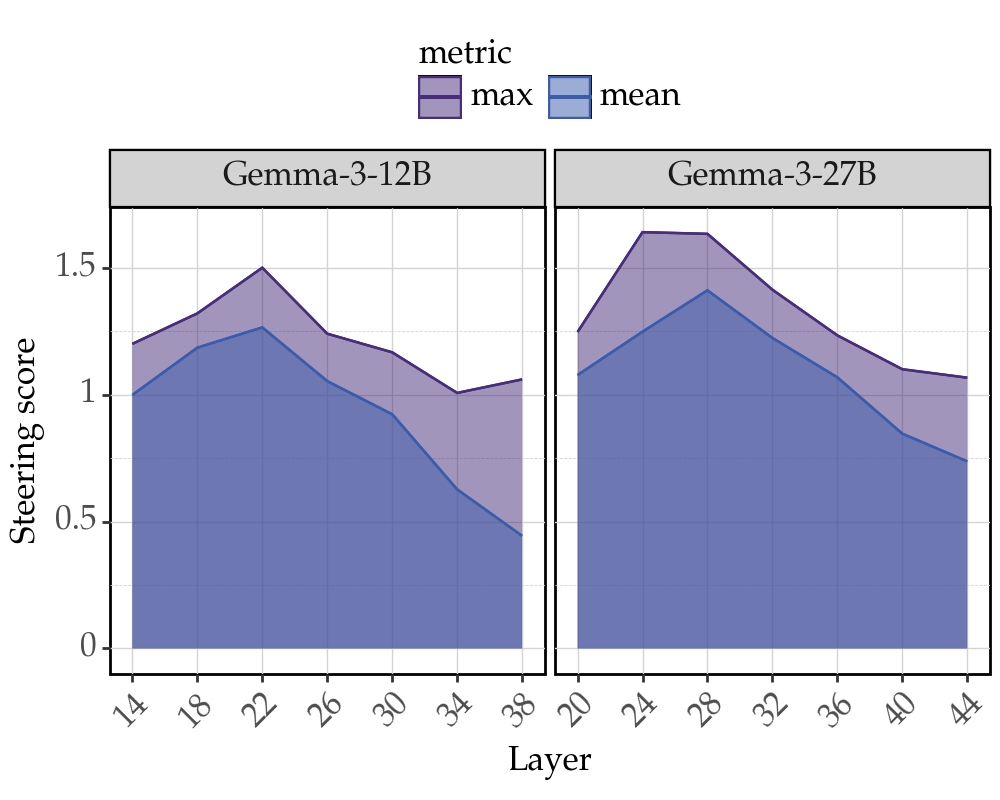

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//steering_per_layer.pdf


In [68]:
# Reset index to make 'layer' a column
layer_select_12_df = layer_select_12.reset_index()
layer_select_12_df["model"] = "Gemma-3-12B"

layer_select_27_df = layer_select_27.reset_index()
layer_select_27_df["model"] = "Gemma-3-27B"

# Combine dataframes
combined_df = pd.concat([layer_select_12_df, layer_select_27_df])

# Melt the dataframe for ggplot
melted_df = pd.melt(
    combined_df, 
    id_vars=["layer", "model", "var"], 
    value_vars=["max", "mean"],
    var_name="metric", 
    value_name="value"
)

# Convert to categorical for proper ordering
melted_df["layer"] = pd.Categorical(melted_df["layer"], categories=sorted(melted_df["layer"].unique()), ordered=True)
melted_df["model"] = pd.Categorical(melted_df["model"], categories=["Gemma-3-12B", "Gemma-3-27B"], ordered=True)
melted_df["metric"] = pd.Categorical(melted_df["metric"], categories=["max", "mean"], ordered=True)

# Define the color palette
# ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
metric_colors = ['#472d7b', '#3a5cac']

# Calculate maximum values for each model and metric
max_values = melted_df.groupby(['model', 'metric'])['value'].max().reset_index()

# Create the plot
plot = (
    ggplot(melted_df, aes(x="layer", y="value", color="metric", fill="metric", group="metric"))
    + geom_area(alpha=0.5, position="identity")
    + stat_summary(fun_data="mean_cl_boot", geom="line")
    + facet_wrap("~ model", ncol=2, scales="free_x")
    + labs(x="Layer", y="Steering score")
    + scale_color_manual(values=metric_colors)
    + scale_fill_manual(values=metric_colors)
    # Add annotations for maximum values
    + theme(
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=12),
        plot_title=element_text(size=0),
        axis_text=element_text(size=12),
        axis_title=element_text(size=12),
        legend_position='top',
        legend_box='horizontal',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=12),
        legend_text=element_text(size=12),
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        figure_size=(5, 4),
        panel_spacing=0.01,
    )
    + scale_x_discrete(expand=(0.05, 0.05))
    + scale_y_continuous(expand=(0, 0.1))
    + guides(color=guide_legend(nrow=1), fill=guide_legend(nrow=1))
)
print(plot)
plot.save(f"{PLOT_FOLDER}/steering_per_layer.pdf", width=5, height=4)

### Concept detection scores

In [16]:
RESULTS_FOLDERS = [
    "/nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1/",
]
SUBFOLDERS = [
    "prod_2b_l20_concept500",
    "prod_2b_l10_concept500",
    "prod_9b_l20_concept500",
    "prod_9b_l31_concept500",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
    # "prod_27b_l28_concept100"
    # "prod_12b_l22_concept100"
    # "prod_12b_l18_concept100"
]
METHODS = [
    # RePS v.s. Lang. in SV
    "dps",
    "c_vector",
]
METHOD_MAP = {
    "PreferenceVector": "SV w/ RePS",
    "ConceptVector": "SV w/ Lang.",
    "PreferenceLoRA": "LoRA w/ RePS",
    "ConceptLoRA": "LoRA w/ Lang.",
    "PreferenceLoReFT": "LoReFT w/ RePS",
    "ConceptLoReFT": "LoReFT w/ Lang.",
    # "PromptSteering": "Prompt",
    # "GemmaScopeSAE": "SAE",
    # "c_vector_nfs": "LM w/o factor",
    # "p_lora_dps": "p_lora_dps",
    # "p_vector_bipo_lf": "p_vector_bipo_lf",
    # "p_loreft_dps": "p_loreft_dps",
    # "p_loreft_bipo": "p_loreft_bipo",
    # "c_loreft": "c_loreft",
    # "p_lora_bipo": "p_lora_bipo",
    # "c_lora": "c_lora",
    # "p_vector_dps": "p_vector_dps", 
    # "prompt_steering": "Prompt",
    # "prompt": "Prompt"
}

In [17]:
reload = True
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    all_dfs = []
    for results_folder in RESULTS_FOLDERS:
        for folder in SUBFOLDERS:
            parts = folder.split("_")
            assert len(parts) == 4
            _, model, layer, split = parts
            dfs = []
            for method in METHODS:
                df = process_folder(results_folder, folder, method)
                if df is not None:
                    dfs.append(df)
                    print(len(df))
                    # for column in df.columns:
                    #     print(column, df[column].iloc[0])
        
            # merge dfs based on concept_id column, pick the first one
            if len(dfs) == 0:
                continue
            df = pd.concat(dfs)
            # print(list(df.columns))
            # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
            df = df.groupby("concept_id").first().reset_index()
            df["model"] = MODEL_MAP[model]
            df["layer"] = LAYER_MAP[layer]
            df["split"] = split
            df["identifier"] = f"{model}, {layer}, {split}"
            all_dfs.append(format_df(df))

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_dps/evaluate
Processing latent for dps...
Processing latent (more) for dps...
Processing steering for dps...
Processing steering test for dps...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l20_concept500_c_vector/evaluate
Processing latent for c_vector...
Processing latent (more) for c_vector...
Processing steering for c_vector...
Processing steering test for c_vector...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l10_concept500_dps/evaluate
Processing latent for dps...
Processing latent (more) for dps...
Processing steering for dps...
Processing steering test for dps...
500
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept500_v1//prod_2b_l10_concept500_c_vector/evaluate
Processing latent for c_vector...
Processing latent (more) for c_vector...
Processing steering for c_vector...
Processing 

In [18]:
ignore = []
split = "concept500"
df_all = df.copy()
df = df[~df["Method"].isin(ignore)]
df["Method"].unique()

array(['SV w/ Lang.', 'SV w/ RePS'], dtype=object)

In [19]:
# make latex table
detection_order = []
steering_order = []
for metric in ["AUROC", "Overall Score", "Overall Accuracy", "F1", "Precision", "Recall"]:
    with open(f"{PLOT_FOLDER}/{split}_{metric}.txt", "w") as f:
        for only_mean in [True, False]:
            df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
            df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
            # print count of nans
            f.write("NaN count:\n")
            for method in df_subset["Method"].unique():
                f.write(f"{method}: {sum(df_subset[df_subset['Method'] == method]['values'].apply(lambda x: np.isnan(x)))}\n")
            avg_df = df_subset.copy()
            avg_df["identifier"] = "Average"
            df_subset = pd.concat([df_subset, avg_df])
            df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
            
            # Append the averages to the original dataframe
            df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
            df_subset = df_subset.sort_values(by="Average", ascending=False)

            # df_subset_avg = df.copy()
            # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
            # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
            # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
            # df_subset = df_subset.sort_values(by="Average", ascending=False)
            if metric == "AUROC":
                detection_order = df_subset["Method"].tolist()
            elif metric == "Overall Score":
                steering_order = df_subset["Method"].tolist()
            elif metric in ["Winrate"]:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
            else:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
            flattened = df_subset.to_latex(index=False)
            f.write(flattened)
            f.write("\n\n")

        # do paired t test on Latent AUROC between each pair of methods
        df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
        df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
        for identifier in list(df_subset["identifier"].unique()) + [None]:
            for method1, method2 in itertools.combinations(df["Method"].unique(), 2):
                df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
                if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                    continue
                roc_auc_1 = list(df_subset_t[method1])
                roc_auc_2 = list(df_subset_t[method2])
                # print all nans
                method1_nan = sum(np.isnan(roc_auc_1))
                method2_nan = sum(np.isnan(roc_auc_2))
                if method1_nan > 0 or method2_nan > 0:
                    # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                    continue
                t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
                f.write(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}\n")

/tmp/wuzhengx/ipykernel_3733755/480875006.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/wuzhengx/ipykernel_3733755/480875006.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/wuzhengx/ipykernel_3733755/480875006.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclud

In [20]:
# make a new df from the lists roc_curve.fpr and roc_curve.tpr
common_fpr = np.linspace(0, 1, 38)
roc_df = df.copy().dropna(subset=["roc_curve.fpr", "roc_curve.tpr"])
fprs = [val for val in roc_df["roc_curve.fpr"]]
tprs = [val for val in roc_df["roc_curve.tpr"]]
for i in range(len(fprs)):
    tprs[i] = [0.0] + list(np.interp(common_fpr, fprs[i], tprs[i]))
    fprs[i] = [0.0] + list(common_fpr)
roc_dict = {
    "fpr": [x for val in fprs for x in val],
    "tpr": [x for val in tprs for x in val],
}
# for key in ["fpr", "tpr"]:
#     for val in roc_df[f"roc_curve.{key}"]:
#         vals = []
#         for x in val:
#             if len(vals) != 0:
#                 if key == "fpr": vals.append(x)
#                 else: vals.append(vals[-1])
#             vals.append(x)
#         roc_dict[key].extend(vals)
lens = [len(val) for val in fprs]
for col in id_vars + ["Method"]:
    roc_dict[col] = [val for i, val in enumerate(roc_df[col]) for _ in range(lens[i])]
roc_df = pd.DataFrame(roc_dict)
roc_mean_df = roc_df.groupby(['model', 'layer', 'split', 'identifier', 'Method', 'fpr']).mean().reset_index()
roc_mean_df["Method"] = pd.Categorical(roc_mean_df["Method"], categories=detection_order)
roc_df["Method"] = pd.Categorical(roc_df["Method"], categories=detection_order)
print("Main ROC DF", len(roc_df))
print("Mean ROC DF", len(roc_mean_df))

Main ROC DF 156000
Mean ROC DF 304


In [21]:
plot = (
    ggplot(roc_mean_df, aes(x="fpr", y="tpr", color="Method", group="Method"))
    + facet_wrap('model + ": " + layer')
    + geom_line(size=0.8)
    + labs(x="False Positive Rate", y="True Positive Rate")
    + scale_color_manual(values=metric_colors)
    + scale_fill_manual(values=metric_colors)
    + theme(
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=12),
        plot_title=element_text(size=0),
        axis_text=element_text(size=12),
        axis_title=element_text(size=12),
        legend_position='top',
        legend_box='horizontal',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_key_size=12,
        legend_title=element_text(size=12),
        legend_text=element_text(size=12),
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        figure_size=(5, 6),
    )
    + scale_x_continuous(expand=(0.05, 0.05))
    + scale_y_continuous(expand=(0.05, 0.05))
    + guides(color=guide_legend(nrow=1))
)
plot
plot.save(f"{PLOT_FOLDER}/roc_mean.pdf", width=5, height=6)

NameError: name 'metric_colors' is not defined

### Genre-based correction

In [130]:
RESULTS_FOLDERS = [
    "/nlp/scr/wuzhengx/preference-vectors/axbench/results_concept100/",
]
SUBFOLDERS = [
    # "prod_2b_l20_concept500",
    # "prod_2b_l10_concept500",
    # "prod_9b_l20_concept500",
    # "prod_9b_l31_concept500",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
    "prod_27b_l28_concept100",
    "prod_12b_l22_concept100"
    # "prod_12b_l18_concept100"
]
METHODS = [
    # RePS v.s. Lang. in SV
    "dps",
    "c_vector",
    # RePS v.s. Lang. in LoRA
    "p_lora_dps",
    "c_lora",
]
METHOD_MAP = {
    "PreferenceVector": "SV w/ RePS",
    "ConceptVector": "SV w/ Lang.",
    "PreferenceLoRA": "LoRA w/ RePS",
    "ConceptLoRA": "LoRA w/ Lang.",
    "PreferenceLoReFT": "LoReFT w/ RePS",
    "ConceptLoReFT": "LoReFT w/ Lang.",
    # "PromptSteering": "Prompt",
    # "GemmaScopeSAE": "SAE",
    # "c_vector_nfs": "LM w/o factor",
    # "p_lora_dps": "p_lora_dps",
    # "p_vector_bipo_lf": "p_vector_bipo_lf",
    # "p_loreft_dps": "p_loreft_dps",
    # "p_loreft_bipo": "p_loreft_bipo",
    # "c_loreft": "c_loreft",
    # "p_lora_bipo": "p_lora_bipo",
    # "c_lora": "c_lora",
    # "p_vector_dps": "p_vector_dps", 
    # "prompt_steering": "Prompt",
    # "prompt": "Prompt"
}

In [131]:
reload = True
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    all_dfs = []
    for results_folder in RESULTS_FOLDERS:
        for folder in SUBFOLDERS:
            parts = folder.split("_")
            assert len(parts) == 4
            _, model, layer, split = parts
            dfs = []
            for method in METHODS:
                df = process_folder(results_folder, folder, method)
                if df is not None:
                    dfs.append(df)
                    print(len(df))
                    # for column in df.columns:
                    #     print(column, df[column].iloc[0])
        
            # merge dfs based on concept_id column, pick the first one
            if len(dfs) == 0:
                continue
            df = pd.concat(dfs)
            # print(list(df.columns))
            # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
            df = df.groupby("concept_id").first().reset_index()
            df["model"] = MODEL_MAP[model]
            df["layer"] = LAYER_MAP[layer]
            df["split"] = split
            df["identifier"] = f"{model}, {layer}, {split}"
            all_dfs.append(format_df(df))

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept100//prod_27b_l28_concept100_dps/evaluate
Skipping dps because no latent.jsonl found
Skipping dps because no latent.parquet found
Processing steering for dps...
Processing steering test for dps...
100
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept100//prod_27b_l28_concept100_c_vector/evaluate
Skipping c_vector because no latent.jsonl found
Skipping c_vector because no latent.parquet found
Processing steering for c_vector...
Processing steering test for c_vector...
100
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept100//prod_27b_l28_concept100_p_lora_dps/evaluate
Skipping p_lora_dps because no latent.jsonl found
Skipping p_lora_dps because no latent.parquet found
Processing steering for p_lora_dps...
Processing steering test for p_lora_dps...
100
found /nlp/scr/wuzhengx/preference-vectors/axbench/results_concept100//prod_27b_l28_concept100_c_lora/evaluate
Skipping c_lora because no l

In [132]:
ignore = []
split = "concept100"
df_all = df.copy()
df = df[~df["Method"].isin(ignore)]
df["Method"].unique()

array(['LoRA w/ Lang.', 'LoRA w/ RePS', 'SV w/ Lang.', 'SV w/ RePS'],
      dtype=object)

In [133]:
# make latex table
detection_order = []
steering_order = []
for metric in ["Overall Score", ]:
    with open(f"{PLOT_FOLDER}/{split}_{metric}.txt", "w") as f:
        for only_mean in [True, False]:
            df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
            df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
            # print count of nans
            f.write("NaN count:\n")
            for method in df_subset["Method"].unique():
                f.write(f"{method}: {sum(df_subset[df_subset['Method'] == method]['values'].apply(lambda x: np.isnan(x)))}\n")
            avg_df = df_subset.copy()
            avg_df["identifier"] = "Average"
            df_subset = pd.concat([df_subset, avg_df])
            df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
            
            # Append the averages to the original dataframe
            df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
            df_subset = df_subset.sort_values(by="Average", ascending=False)

            # df_subset_avg = df.copy()
            # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
            # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
            # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
            # df_subset = df_subset.sort_values(by="Average", ascending=False)
            if metric == "AUROC":
                detection_order = df_subset["Method"].tolist()
            elif metric == "Overall Score":
                steering_order = df_subset["Method"].tolist()
            elif metric in ["Winrate"]:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
            else:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
            flattened = df_subset.to_latex(index=False)
            f.write(flattened)
            f.write("\n\n")

        # do paired t test on Latent AUROC between each pair of methods
        df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
        df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
        for identifier in list(df_subset["identifier"].unique()) + [None]:
            for method1, method2 in itertools.combinations(df["Method"].unique(), 2):
                df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
                if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                    continue
                roc_auc_1 = list(df_subset_t[method1])
                roc_auc_2 = list(df_subset_t[method2])
                # print all nans
                method1_nan = sum(np.isnan(roc_auc_1))
                method2_nan = sum(np.isnan(roc_auc_2))
                if method1_nan > 0 or method2_nan > 0:
                    # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                    continue
                t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
                f.write(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}\n")

/tmp/wuzhengx/ipykernel_966630/2221883113.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/wuzhengx/ipykernel_966630/2221883113.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [119]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]

model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
plot = (
    ggplot(df_subset, aes(x="Steering Factor", fill="Method"))
    + geom_histogram(bins=21)
    + facet_grid('model + layer ~ Method')
    + labs(x="Optimal steering factor", y="Count", fill="")
    + scale_x_log10()
    # Use one of these color scales depending on your preference:
    + scale_fill_manual(values=model_colors[:len(df_subset["Method"].unique())])  # Using your custom colors 
    # + scale_fill_gradientn(colors=viridis_colors)  # Or using Viridis
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position="none",  # Keeping your preference for no legend
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(8, 5),
    )
)

# plot
plot.save(f"{PLOT_FOLDER}/{split}_optimal_factor_g3.pdf", width=9, height=5) 

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 9 x 5 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept100_optimal_factor_g3.pdf


In [ ]:
# plot each steering metric
df_subset = df.copy()[["Method", "model", "layer", "identifier", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
df_subset = df_subset.dropna(subset=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score", "model", "layer"])
df_subset = df_subset.melt(id_vars=["Method", "model", "layer", "identifier"], value_vars=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score"], var_name="metric", value_name="value")
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=[x for x in steering_order if x not in ignore])
# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']
method_order = sorted(df_subset["Method"].unique())
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=method_order, ordered=True)
plot = (
    ggplot(df_subset, aes(x="Method", y="value", fill='model + ": " + layer'))
    + facet_grid("metric~")
    + geom_boxplot(outlier_shape="", position=position_dodge2(preserve="single"))
    + labs(fill="", y="Score")
    + scale_fill_manual(values=model_colors)
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        axis_text_x=element_text(angle=0, hjust=0.5),
        # Legend styling
        legend_position="top",
        legend_box="horizontal",
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        # Figure size
        figure_size=(9, 6),
    )
    + guides(fill=guide_legend(ncol=4))
)
# plot
plot.save(f"{PLOT_FOLDER}/{split}_steering_g3.pdf", width=9, height=6)

In [134]:
# plot factor vs score
factor_df = df_all.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if x not in no_factor])

In [135]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if (x not in no_factor) and (x not in ignore)])
factor_df = factor_df_og.melt(id_vars=id_vars + ["Method", "Steering Factor"], value_vars=["Overall Score", "Concept Score", "Instruct Score", "Fluency Score"], var_name="metric", value_name="value")
# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Get alphabetically sorted methods
method_order = sorted(factor_df["Method"].unique())

# Define the color palette
model_colors = ['#472d7b', '#3a5cac', '#39a9bc', '#5dc863', '#b8de29', '#fee529', '#ffa600', '#d62828']

# Get alphabetically sorted methods
method_order = sorted(factor_df["Method"].unique())

# Convert Method to categorical with alphabetical order
factor_df["Method"] = pd.Categorical(factor_df["Method"], categories=method_order, ordered=True)

plot = (
    ggplot(factor_df, aes(x="Steering Factor", y="value", color="Method"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("metric~model + layer", scales="free_y")
    + labs(x="Steering factor", y="Score")
    + scale_color_manual(values=model_colors[:len(method_order)])
    + theme(
        # Style for facet labels
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        # No main title
        plot_title=element_text(size=0),
        # Axis styling
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        # Legend styling
        legend_position='top',  # Changed from right to top
        legend_box='horizontal',  # Changed from vertical to horizontal
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        # Grid and panel styling
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
    )
    + guides(color=guide_legend(nrow=1))  # 2 rows of legend entries
)

plot.save(f"{PLOT_FOLDER}/{split}_steering_factor_g3.pdf", width=9, height=6)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 9 x 6 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept100_steering_factor_g3.pdf


In [139]:
concept_map = {
    ("Gemma-3-27B", "L28"): "../concept500_v1/prod_9b_l20_v1/generate/metadata.jsonl",
    ("Gemma-3-12B", "L22"): "../concept500_v1/prod_9b_l20_v1/generate/metadata.jsonl",
}
all_concept_genre_map = {}
for key, value in concept_map.items():
    concept_genre = {}
    with open(value, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue  # skip empty lines
            try:
                record = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON on line {line_number}: {e}")
                continue
            concept_genre[record["concept_id"]] = record["concept_genres_map"][record["concept"]][0]
    all_concept_genre_map[key] = concept_genre

In [140]:
def lookup_genre(row):
    return all_concept_genre_map.get((row['model'], row['layer']), {}) \
                                 .get(row['concept_id'], None)
# plot factor vs score
records = []
for (model, layer), cmap in all_concept_genre_map.items():
    for cid, genre in cmap.items():
        records.append({'model': model, 'layer': layer, 'concept_id': cid, 'genre': genre})
mapping_df = pd.DataFrame(records)
factor_df = factor_df.merge(mapping_df, on=['model', 'layer', 'concept_id'], how='left')

In [143]:
# Filter to only include Overall Score
overall_score_df = factor_df[factor_df["metric"] == "Overall Score"].copy()

# Create combined model+layer identifier
overall_score_df["model_layer"] = overall_score_df["model"] + " " + overall_score_df["layer"]

# Convert model_layer to categorical for proper ordering
model_layer_order = sorted(overall_score_df["model_layer"].unique())
overall_score_df["model_layer"] = pd.Categorical(overall_score_df["model_layer"], categories=model_layer_order, ordered=True)

# Create the plot with genres as colored lines and faceted by Method
plot = (
    ggplot(overall_score_df, aes(x="Steering Factor", y="value", color="genre", group="genre"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("model_layer~Method", scales="free_y")
    + labs(x="Steering factor", y="Steering score", color="Genre")
    + scale_color_manual(values=model_colors[:len(method_order)])
    + theme(
        strip_background=element_rect(fill='lightgray', color='black', size=0.8),
        strip_text=element_text(size=10),
        axis_text=element_text(size=10),
        axis_title=element_text(size=10),
        legend_position='top',
        legend_box='horizontal',
        legend_key=element_rect(color='black', fill='white', size=0.8),
        legend_title=element_text(size=10),
        legend_text=element_text(size=10),
        panel_grid_major=element_line(color='lightgray', size=0.5),
        panel_grid_minor=element_line(color='lightgray', size=0.3, linetype='dashed'),
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
    )
    + guides(color=guide_legend(nrow=1))
)
plot
plot.save(f"{PLOT_FOLDER}/{split}_steering_factor_by_genre_g3.pdf", width=6, height=4.6)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4.6 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper//concept100_steering_factor_by_genre_g3.pdf
